# **Research Project (Honours)**

###### *By Mahlatsi Malise Mashilo (202215639)*

### **Forecasting Car Sales in South Africa Using Google Search Data with Post-hoc Explainable AI**
##### *Model Building Notebook*

## 1. Libraries

In [19]:
! pip install pandas numpy matplotlib scikit-learn seaborn plotly statsmodels shap joblib openpyxl prophet lightgbm EMD-signal tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import itertools
import logging
import random
import pandas as pd, numpy as np, seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from PyEMD import EEMD

import os, joblib
import openpyxl

import tensorflow as tf

import keras
from pathlib import Path

from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
from scipy.signal import windows, savgol_filter
from scipy.stats import boxcox, norm

# Deep learning
from keras.models import Sequential
from keras.layers import GRU, LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2


from prophet import Prophet
# Disable Prophet logs
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

import lightgbm as lgb
# Optional: Disable LightGBM info messages
lgb.basic_config = {'verbose': -1}

from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# SARIMA, LSSVR
import statsmodels.api as sm
from sklearn.svm import SVR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Reproducibility Setup
SEED = 42

# Python random seed
random.seed(SEED)

# NumPy seed
np.random.seed(SEED)

# TensorFlow seed
tf.random.set_seed(SEED)

# For reproducibility in TensorFlow (disable nondeterministic ops)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# Disable TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## 2. Importing Final Datasts

In [3]:
# Folder containing the datasets
input_folder = Path("final_datasets")

# Dictionary to hold the loaded DataFrames
loaded_dfs = {}

# Loop through all Excel files except 'final_df.xlsx'
for file in input_folder.glob("*.xlsx"):
    if file.name == "final_df.xlsx":
        continue
    
    # Use the filename without extension as the variable name
    var_name = file.stem
    loaded_dfs[var_name] = pd.read_excel(file, index_col=0)  # preserve index if any

# Optionally, assign to variables in global namespace (careful with this in scripts)
globals().update(loaded_dfs)

# Check loaded DataFrames
print("Loaded datasets:")
for name, df in loaded_dfs.items():
    print(f"- {name}: {df.shape}")

Loaded datasets:
- X1_test: (41, 13)
- X1_train: (213, 13)
- X2_test: (41, 10)
- X2_train: (213, 10)
- y1_test: (41, 1)
- y1_train: (213, 1)
- y2_test: (41, 1)
- y2_train: (213, 1)


In [4]:
# Folder containing the scalers
input_folder = Path("final_scalers")

# Load fitted scalers back
X1_scaler = joblib.load(input_folder / "X1_scaler.pkl")
X2_scaler = joblib.load(input_folder / "X2_scaler.pkl")
y1_scaler = joblib.load(input_folder / "y1_scaler.pkl")
y2_scaler = joblib.load(input_folder / "y2_scaler.pkl")

print("Scalers loaded successfully.")

Scalers loaded successfully.


## 3. Ensemble Empirical Mode Decomposition (EEMD)

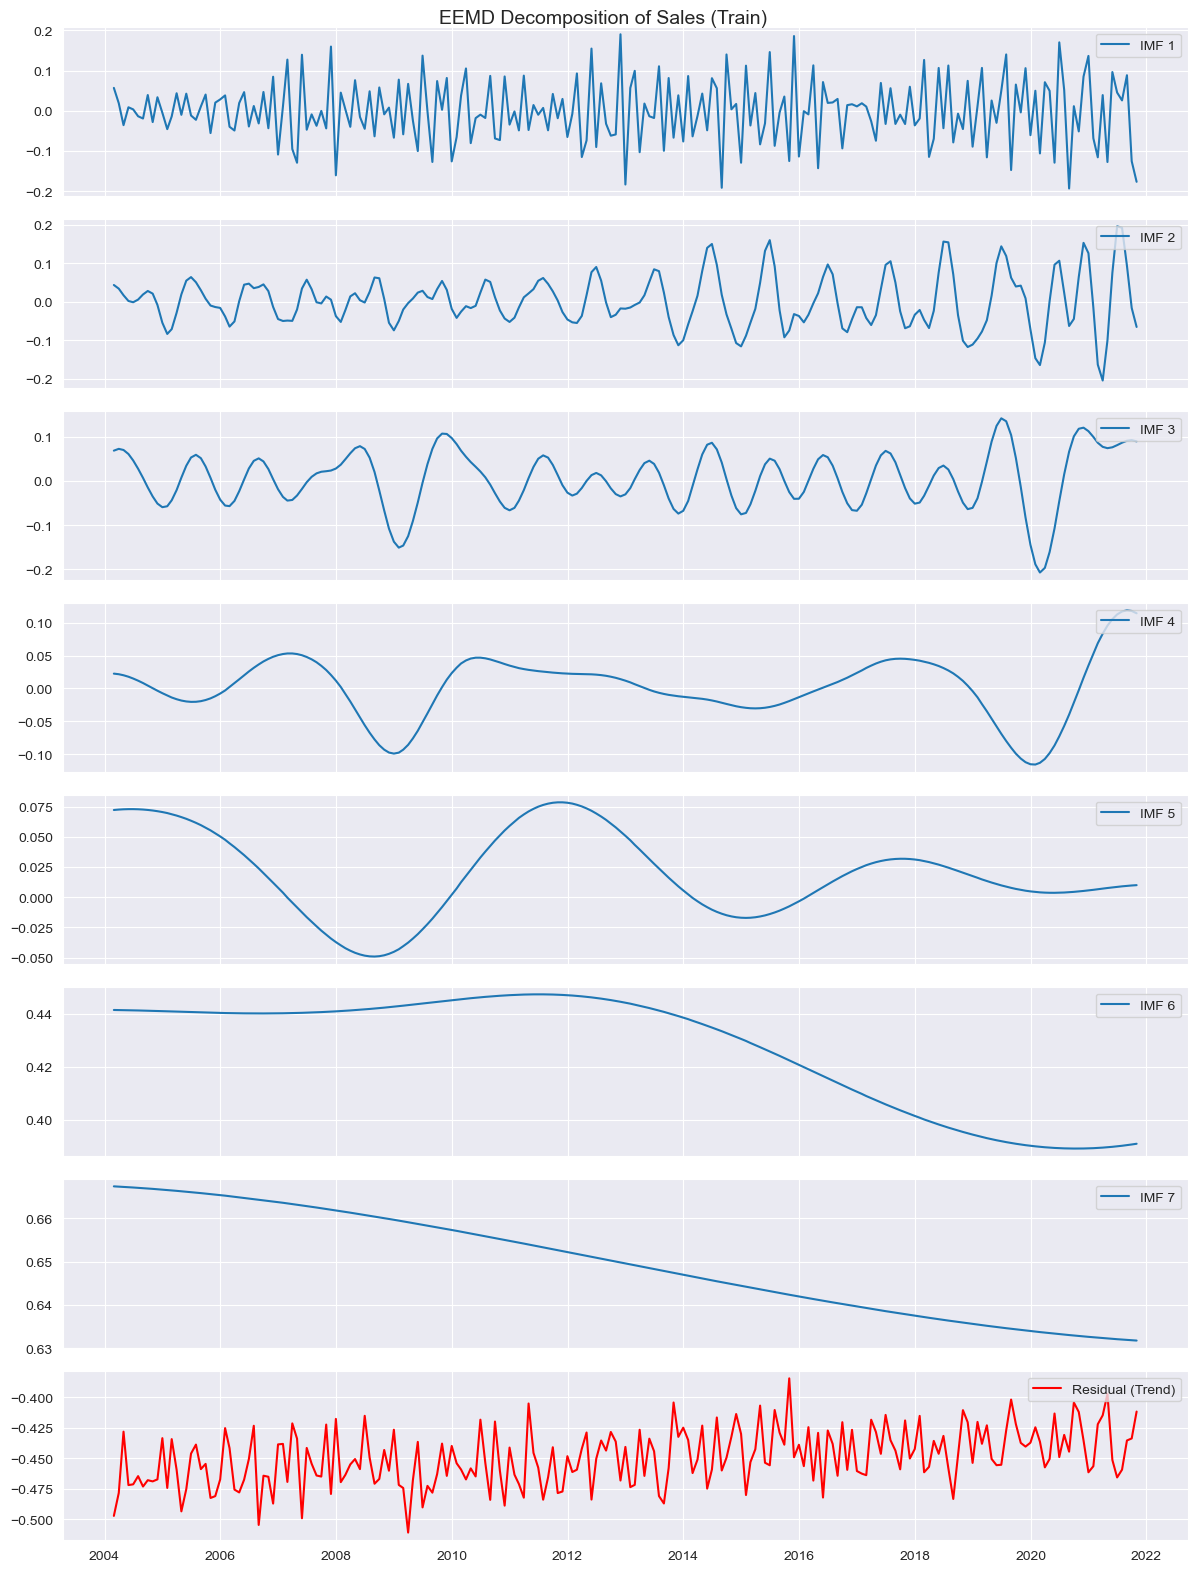

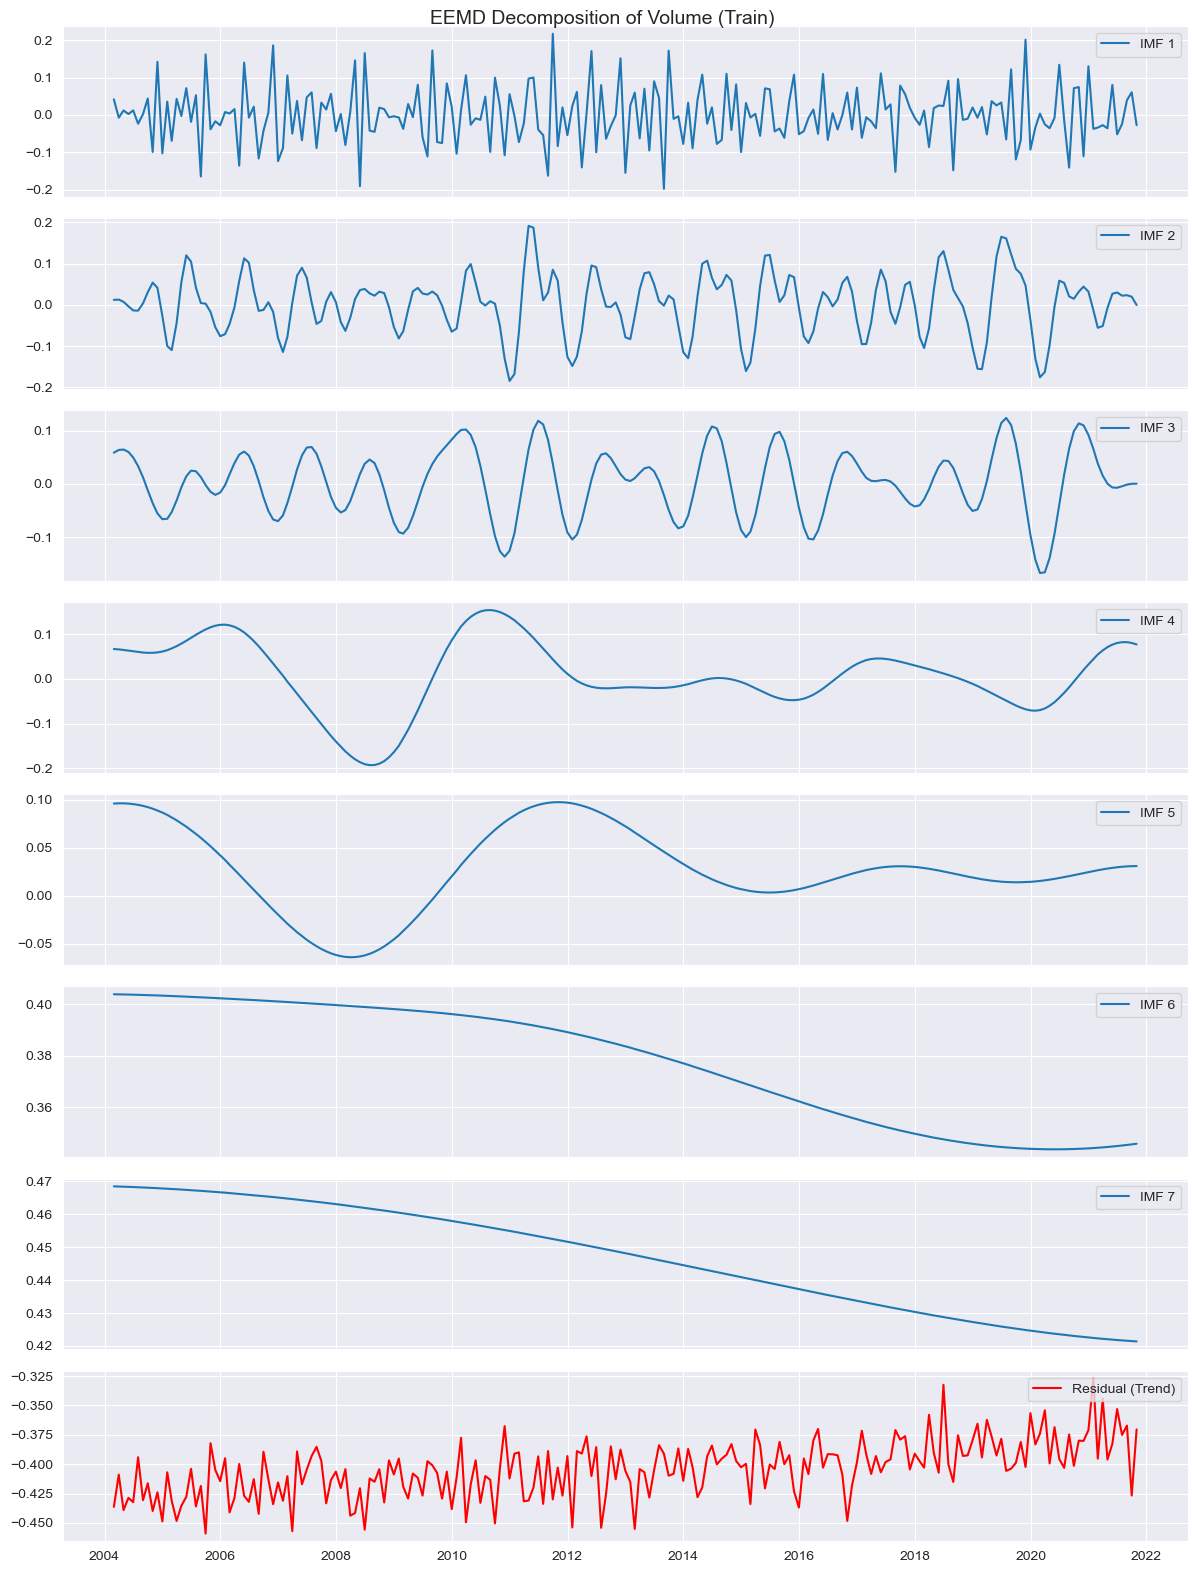

In [5]:
# === EEMD to create Intrinsic Mode Functions (IMFs) ===
def run_eemd(series, series_name="Series", noise_width=0.2, n_ensembles=100, max_imf=8, plot=True):
    """
    Decompose training series using EEMD.
    Returns IMFs (n_imfs, len(series)) and residual.
    """
    eemd = EEMD()
    eemd.noise_width = noise_width
    eemd.trials = n_ensembles

    series = series.dropna()
    X = series.values.flatten()
    t = np.arange(len(series))

    imfs = eemd.eemd(X, t, max_imf)
    residual = X - np.sum(imfs, axis=0)

    if plot:
        n_imfs = imfs.shape[0]
        fig, axes = plt.subplots(n_imfs+1, 1, figsize=(12, 2*(n_imfs+1)), sharex=True)
        for i in range(n_imfs):
            axes[i].plot(series.index, imfs[i], label=f'IMF {i+1}')
            axes[i].legend(loc='upper right')
        axes[-1].plot(series.index, residual, label="Residual (Trend)", color="red")
        axes[-1].legend(loc='upper right')
        plt.suptitle(f"EEMD Decomposition of {series_name}", fontsize=14)
        plt.tight_layout()
        plt.show()

    return imfs, residual


# Example decomposition
sales_imfs, sales_residual = run_eemd(y1_train, "Sales (Train)")
volume_imfs, volume_residual = run_eemd(y2_train, "Volume (Train)")

eemd_results = {
    "sales": {"imfs": sales_imfs, "residual": sales_residual},
    "volume": {"imfs": volume_imfs, "residual": volume_residual}
}


## 4. Lag Selection and ARX Preparation

In [6]:
# === Lagged Feature Creator ===
def create_features(y_train, y_test, X_train, X_test, lags, series_name):
    """Generate lagged features + align train/test with exogenous features."""
    # Train lags
    lagged_train = pd.DataFrame(index=y_train.index)
    for lag in range(1, lags + 1):
        lagged_train[f"{series_name}_lag{lag}"] = y_train.shift(lag)
    X_train = pd.concat([lagged_train, X_train], axis=1).dropna()
    y_train = y_train.loc[X_train.index]

    # Test lags (use last lags from train to seed)
    combined = pd.concat([y_train.tail(lags), y_test])
    lagged_test = pd.DataFrame(index=combined.index)
    for lag in range(1, lags + 1):
        lagged_test[f"{series_name}_lag{lag}"] = combined.shift(lag)
    lagged_test = lagged_test.iloc[lags:]
    
    X_test = pd.concat([lagged_test.reset_index(drop=True),
                        X_test.reset_index(drop=True)], axis=1)
    y_test = y_test.reset_index(drop=True).iloc[:len(X_test)]

    return X_train, X_test, y_train, y_test


# Apply with correct lag structure
X1_train_lagged, X1_test_lagged, y1_train_lagged, y1_test_lagged = create_features(y1_train, y1_test, X1_train, X1_test, lags=1, series_name="Sales")
X2_train_lagged, X2_test_lagged, y2_train_lagged, y2_test_lagged = create_features(y2_train, y2_test, X2_train, X2_test, lags=2, series_name="Volume")

## 5. Modelling

The plan is to investigate the effect of search data on the sales and volume using 5 different models. These models are given below:

<table style="width:100%">
  <thead>
    <tr>
      <th>Model</th>
      <th>Description</th>
      <th>Model Category</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>SARIMA / SARIMAX</td>
      <td>Captures linear seasonality and trend but limited in handling nonlinear patterns.</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSSVR</td>
      <td>Least Squares SVM regression. Strong at capturing nonlinear relationships, though it requires careful hyperparameter tuning.</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSTM</td>
      <td>Sequential neural model for time series. Learns long-term dependencies and nonlinearities but can be computationally heavy.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>BiLSTM</td>
      <td>Captures both forward and backward dependencies in sequences, offering richer temporal context than unidirectional LSTM.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>CNN-LSTM</td>
      <td>Combines CNN (local feature extraction) with LSTM (temporal learning). Effective for complex time series with both short- and long-term dependencies.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>GRU</td>
      <td>A simplified version of LSTM with fewer parameters. Trains faster while retaining the ability to model temporal dependencies.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>Prophet</td>
      <td>Additive time series model developed by Facebook. Designed for business forecasting, handles seasonality, holidays, and missing data robustly.</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LightGBM</td>
      <td>Gradient boosting framework optimized for speed and efficiency. Handles high-dimensional data well, supports feature importance analysis, and is strong at capturing nonlinear interactions.</td>
      <td>Machine Learning</td>
    </tr>
  </tbody>
</table>


### a. Determining Sarima Order

In [7]:
def fit_sarimax_and_forecast(y_train, X_train=None, X_forecast=None,
                             order=(1,1,0), seasonal_order=(0,0,0,0),
                             trend='c', steps=None):
    """
    Fit SARIMAX and return fitted results, forecast mean and conf_int DataFrame.
    y_train: pd.Series (train)
    X_train: pd.DataFrame or None (aligned to y_train)
    X_forecast: pd.DataFrame or None (exog for forecast horizon length)
    order, seasonal_order: SARIMAX orders
    trend: 'c'|'t'|None etc.
    steps: integer forecast horizon (if None and X_forecast provided then len(X_forecast))
    """
    model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order, trend=trend,
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    if steps is None:
        steps = len(X_forecast) if X_forecast is not None else 0
    if steps == 0:
        # nothing to forecast
        return res, None, None
    # If exog for forecast provided, pass it; else forecast without exog
    forecast_obj = res.get_forecast(steps=steps, exog=X_forecast)
    pred = forecast_obj.predicted_mean
    ci = forecast_obj.conf_int()
    # ensure index for pred/ci: create a datetime index if y_train has datetime and X_forecast has index
    if X_forecast is not None and hasattr(X_forecast, "index"):
        pred.index = X_forecast.index[:len(pred)]
        ci.index = X_forecast.index[:len(ci)]
    else:
        # fallback: create RangeIndex starting after y_train
        start_idx = y_train.index[-1] if hasattr(y_train.index, 'dtype') and np.issubdtype(y_train.index.dtype, np.datetime64) else None
        # if we can't set, leave as is
    return res, pred, ci

def compare_sarimax_candidates(y_train, y_test, X_train=None, X_test=None, candidates=None):
    """
    Fit multiple SARIMAX candidates and return a small table comparing AIC/BIC/RMSE.
    candidates: list of dicts with keys 'order','seasonal_order','trend','name'
    """
    rows = []
    for c in candidates:
        res, pred, ci = fit_sarimax_and_forecast(y_train, X_train=X_train, X_forecast=X_test,
                                                order=c['order'], seasonal_order=c.get('seasonal_order',(0,0,0,0)),
                                                trend=c.get('trend','c'))
        if pred is None:
            continue
        # align y_test and pred
        y_true = y_test.values.flatten()
        y_hat = pred.values.flatten()[:len(y_true)]
        rmse = np.sqrt(np.mean((y_true - y_hat)**2))
        rows.append({
            "name": c.get('name'),
            "order": c['order'],
            "seasonal_order": c.get('seasonal_order'),
            "trend": c.get('trend','c'),
            "AIC": round(getattr(res, 'aic', np.nan), 3),
            "RMSE": round(rmse, 3)
        })
    return pd.DataFrame(rows).sort_values("RMSE")

In [8]:
# Determining which Sarimax model order to use
sales_candidates = [
    {"name":"Sales_ARIMA110_drift", "order":(1,1,0), "seasonal_order":(0,0,0,0), "trend":"t"},
    {"name":"Sales_ARIMA110_seasonalMA", "order":(1,1,0), "seasonal_order":(0,0,1,12), "trend":"t"},
    {"name":"Sales_ARIMA110_seasonalDiffMA", "order":(1,1,0), "seasonal_order":(0,1,1,12), "trend":"t"},
]

sales_table = compare_sarimax_candidates(y1_train_lagged, y1_test_lagged, X_train=X1_train_lagged, X_test=X1_test_lagged, candidates=sales_candidates)
sales_table

# Result: Model 1 (Sales_ARIMA110_seasonalMA) is the best when compared

,name,order,seasonal_order,trend,AIC,RMSE
1,Sales_ARIMA110_seasonalMA,"(1, 1, 0)","(0, 0, 1, 12)",t,-217.989,0.291
0,Sales_ARIMA110_drift,"(1, 1, 0)","(0, 0, 0, 0)",t,-226.886,0.314
2,Sales_ARIMA110_seasonalDiffMA,"(1, 1, 0)","(0, 1, 1, 12)",t,-205.327,0.340


In [9]:
# Volume
volume_candidates = [
    {"name":"Volume_AR2_const", "order":(2,0,0), "seasonal_order":(0,0,0,0), "trend":"c"},
    {"name":"Volume_AR2_seasonalMA", "order":(2,0,0), "seasonal_order":(0,0,1,12), "trend":"c"},
    {"name":"Volume_AR2_seasonalDiffMA", "order":(2,0,0), "seasonal_order":(0,1,1,12), "trend":"c"},
]

volume_table = compare_sarimax_candidates(y2_train_lagged, y2_test_lagged, X_train=X2_train_lagged, X_test=X2_test_lagged, candidates=volume_candidates)
volume_table

# Result: Model 2 (Volume_AR2_seasonalDiffMA) is the best 

,name,order,seasonal_order,trend,AIC,RMSE
1,Volume_AR2_seasonalMA,"(2, 0, 0)","(0, 0, 1, 12)",c,-214.869,0.118
0,Volume_AR2_const,"(2, 0, 0)","(0, 0, 0, 0)",c,-226.123,0.119
2,Volume_AR2_seasonalDiffMA,"(2, 0, 0)","(0, 1, 1, 12)",c,-218.310,0.131


### b. Helper Functions

In [10]:
# === Evaluation ===
def evaluate_model(y_true, y_pred, model_name="Model",
                   fitted_model=None, conf_int=None, k=None):
    """
    Compute metrics (RMSE, MAE, MAPE, R2, AIC, BIC).
    Returns both metrics dict (rounded to 3 decimals) and DataFrame with predictions.
    """
    # Align indexes
    if hasattr(y_true, "index"):
        index = y_true.index
        y_true = y_true.values.flatten()
    else:
        index = pd.RangeIndex(start=0, stop=len(y_true))
        y_true = np.array(y_true).flatten()

    y_pred = np.array(y_pred).flatten()

    # Residuals
    residuals = y_true - y_pred
    rss, n = np.sum(residuals**2), len(y_true)

    # Metrics
    rmse = np.sqrt(rss / n)
    mae = np.mean(np.abs(residuals))
    mape = np.mean(np.abs(residuals / (y_true + 1e-10)))
    r2 = 1 - rss / np.sum((y_true - np.mean(y_true))**2)

    # AIC/BIC
    aic, bic = np.nan, np.nan
    if fitted_model is not None and hasattr(fitted_model, "aic") and hasattr(fitted_model, "bic"):
        aic, bic = fitted_model.aic, fitted_model.bic
    else:
        if k is None:
            k = 1
        aic = n * np.log(rss / n) + 2 * k
        bic = n * np.log(rss / n) + k * np.log(n)

    # Confidence intervals
    if conf_int is not None:
        ci_lower, ci_upper = conf_int[:, 0], conf_int[:, 1]
    else:
        ci_lower, ci_upper = np.full_like(y_pred, np.nan), np.full_like(y_pred, np.nan)

    df = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "ci_lower": ci_lower,
        "ci_upper": ci_upper
    }, index=index)

    metrics = {
        "Model": model_name,
        "RMSE": round(rmse, 3),
        "MAE": round(mae, 3),
        "MAPE": round(mape, 3),
        "R2": round(r2, 3),
        "AIC": round(aic, 3) if not np.isnan(aic) else np.nan,
        "BIC": round(bic, 3) if not np.isnan(bic) else np.nan
    }
    return metrics, df

# === Classical & ML Models ===
def train_sarimax(y_train, X_train=None, order=(1,1,0), seasonal_order=(0,0,0,0)):
    """SARIMAX (or ARIMA if X_train=None)."""
    model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
    return model.fit(disp=False)

def train_lightgbm(X_train, y_train, params=None):
    """LightGBM regressor."""
    if params is None:
        params = {"objective": "regression", "n_estimators": 200, "learning_rate": 0.05}
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    return model

def train_lssvr(X_train, y_train, C=1.0, gamma="scale"):
    """Approximate LSSVR with sklearn SVR."""
    model = SVR(C=C, gamma=gamma)
    model.fit(X_train, y_train)
    return model


# === Prophet ===
def train_prophet(y_train, X_train=None):
    """Prophet with or without exogenous regressors."""
    df = y_train.reset_index()
    df.columns = ["ds", "y"]
    model = Prophet()
    if X_train is not None:
        for col in X_train.columns:
            model.add_regressor(col)
        df = pd.concat([df, X_train.reset_index(drop=True)], axis=1)
    model.fit(df)
    return model


# Deep Learning Models
def build_lstm(input_shape,
               units=64,
               dropout_rate=0.3,
               l2_lambda=1e-4,
               n_layers=2,
               learning_rate=1e-3):
    """
    Build a stacked, regularized LSTM model for time series forecasting.
    
    Parameters
    ----------
    input_shape : tuple
        (timesteps, features)
    units : int
        Number of hidden units per LSTM layer.
    dropout_rate : float
        Dropout rate for regularization.
    l2_lambda : float
        L2 penalty for kernel weights.
    n_layers : int
        Number of stacked LSTM layers (last one returns sequences=False).
    learning_rate : float
        Learning rate for Adam optimizer.
    """
    model = Sequential()
    
    # First LSTM layer(s)
    for i in range(n_layers - 1):
        model.add(LSTM(units,
                       activation="tanh",
                       return_sequences=True,
                       kernel_regularizer=l2(l2_lambda),
                       input_shape=input_shape if i == 0 else None))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Final LSTM layer
    model.add(LSTM(units,
                   activation="tanh",
                   return_sequences=False,
                   kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Dense output
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse")
    
    return model

# --- BiLSTM ---
def build_bilstm(input_shape,
                 units=64,
                 dropout_rate=0.3,
                 l2_lambda=1e-4,
                 n_layers=2,
                 learning_rate=1e-3):
    """
    Stacked Bidirectional LSTM with dropout, BN, and L2 regularization.
    """
    model = Sequential()
    
    for i in range(n_layers - 1):
        model.add(Bidirectional(
            LSTM(units,
                 activation="tanh",
                 return_sequences=True,
                 kernel_regularizer=l2(l2_lambda)),
            input_shape=input_shape if i == 0 else None
        ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Final BiLSTM (no sequences)
    model.add(Bidirectional(
        LSTM(units,
             activation="tanh",
             return_sequences=False,
             kernel_regularizer=l2(l2_lambda))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse")
    return model


# --- GRU ---
def build_gru(input_shape,
              units=64,
              dropout_rate=0.3,
              l2_lambda=1e-4,
              n_layers=2,
              learning_rate=1e-3):
    """
    Stacked GRU with dropout, BN, and L2 regularization.
    """
    model = Sequential()
    
    for i in range(n_layers - 1):
        model.add(GRU(units,
                      activation="tanh",
                      return_sequences=True,
                      kernel_regularizer=l2(l2_lambda),
                      input_shape=input_shape if i == 0 else None))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    model.add(GRU(units,
                  activation="tanh",
                  return_sequences=False,
                  kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse")
    return model


# --- CNN-LSTM ---
def build_cnn_lstm(input_shape,
                   filters=64,
                   kernel_size=2,
                   lstm_units=50,
                   dropout_rate=0.3,
                   l2_lambda=1e-4,
                   learning_rate=1e-3):
    """
    CNN-LSTM hybrid: Conv1D for local patterns, LSTM for temporal dependencies.
    """
    timesteps = input_shape[0]
    kernel = kernel_size if timesteps >= kernel_size else 1
    
    model = Sequential([
        Conv1D(filters=filters,
               kernel_size=kernel,
               activation="relu",
               kernel_regularizer=l2(l2_lambda),
               input_shape=input_shape),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        LSTM(lstm_units, return_sequences=False,
             kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse")
    return model

# === DL Training with Recursive Forecasting ===
def train_deep_model(model_fn, X_train, y_train, X_test, y_test,
                     epochs=50, batch_size=16, recursive=True, alpha=0.05):
    """
    Train deep learning model (LSTM, GRU, etc.) with optional recursive forecasting.
    Returns:
        model, predictions, prediction intervals (lower, upper)
    """
    # Reshape for 3D input
    n_samples, n_features = X_train.shape
    timesteps = max(1, n_features)  # simplistic: assume 1 timestep per feature if not lagged
    X_train_3d = X_train.reshape((n_samples, timesteps, n_features // timesteps))
    X_test_3d = X_test.reshape((X_test.shape[0], timesteps, n_features // timesteps))

    # Build & fit model
    model = model_fn(input_shape=(X_train_3d.shape[1], X_train_3d.shape[2]))
    model.fit(X_train_3d, y_train, validation_data=(X_test_3d, y_test),
              epochs=epochs, batch_size=batch_size, verbose=0)

    # Predict
    if not recursive:
        y_pred = model.predict(X_test_3d).flatten()
    else:
        y_pred = []
        last_window = X_train_3d[-1]
        for t in range(len(y_test)):
            yhat = model.predict(last_window.reshape(1, *last_window.shape), verbose=0).flatten()[0]
            y_pred.append(yhat)
            # update window
            new_window = last_window.copy()
            new_window[:-1, :] = new_window[1:, :]
            new_window[-1, 0] = yhat
            last_window = new_window
        y_pred = np.array(y_pred)

    # Simple prediction interval (based on training residual std)
    residuals = y_train - model.predict(X_train_3d).flatten()
    std_err = np.std(residuals)
    z = 1.96  # ~95% CI
    ci_lower = y_pred - z * std_err
    ci_upper = y_pred + z * std_err
    ci = np.vstack([ci_lower, ci_upper]).T

    return model, y_pred, ci


def run_all_models(y_train, y_test, X_train=None, X_test=None, label="",
                   series_type="sales", eemd_parts=None,
                   dl_epochs=30, dl_batch_size=16, recursive_ml=True):
    """
    Train/evaluate SARIMAX, LightGBM, LSSVR, Prophet, LSTM, BiLSTM, GRU, CNN-LSTM
    using ARX structure (lags + exogenous).
    - series_type: "sales" or "volume" (decides lag count and SARIMAX config).
    - eemd_parts: optional dict with "imfs" and "residual".
    - recursive_ml: if True, ML/DL forecasts use recursive roll-forward for multi-step.
    Returns:
        local_results (list of metrics dicts),
        local_pred_dfs (dict of prediction DataFrames),
        models (dict of trained models).
    """
    local_results, local_pred_dfs = [], {}
    models = {}

    # ------------------------
    # Configurations
    # ------------------------
    series_type = series_type.lower()
    if series_type not in ("sales", "volume"):
        raise ValueError("series_type must be 'sales' or 'volume'")
    lags = 1 if series_type == "sales" else 2

    sarimax_configs = {
        "sales": {"order": (1, 1, 0), "seasonal_order": (0, 0, 1, 12), "trend": "t"},
        "volume": {"order": (2, 0, 0), "seasonal_order": (0, 1, 1, 12), "trend": "c"}
    }
    sar_cfg = sarimax_configs[series_type]

    # ------------------------
    # Start with provided features
    # ------------------------
    X_train_local = X_train.copy() if X_train is not None else pd.DataFrame(index=y_train.index)
    X_test_local = X_test.copy() if X_test is not None else pd.DataFrame(index=y_test.index)
    y_train_local, y_test_local = y_train.copy(), y_test.copy()

    # Convert for ML/DL
    Xtr_for_ml, Xte_for_ml = X_train_local.values, X_test_local.values
    n_features = Xtr_for_ml.shape[1]

    # ------------------------
    # === SARIMAX ===
    # ------------------------
    sar = train_sarimax(y_train_local, X_train=X_train_local,
                        order=sar_cfg["order"], seasonal_order=sar_cfg["seasonal_order"])
    models['sarimax'] = sar
    sar_forecast = sar.get_forecast(steps=len(y_test_local), exog=X_test_local)
    sar_pred = sar_forecast.predicted_mean
    sar_ci = sar_forecast.conf_int()
    metrics, df = evaluate_model(y_test_local, sar_pred, f"SARIMAX-{label}",
                                 fitted_model=sar, conf_int=sar_ci.values, k=X_train_local.shape[1])
    local_results.append(metrics); local_pred_dfs[f"SARIMAX-{label}"] = df

    # ------------------------
    # === LightGBM (recursive option) ===
    # ------------------------
    lgbm = train_lightgbm(Xtr_for_ml, y_train_local)
    models['lightgbm'] = lgbm
    if recursive_ml:
        preds = []
        test_features = Xte_for_ml.copy()
        for i in range(len(y_test)):
            pred = lgbm.predict(test_features[i].reshape(1, -1))[0]
            preds.append(pred)
            # roll-forward update
            if lags >= 1:
                for lag in range(lags, 0, -1):
                    if lag == 1:
                        test_features[i:, -lag] = pred
                    else:
                        test_features[i:, -lag] = test_features[i:, -(lag-1)]
    else:
        preds = lgbm.predict(Xte_for_ml)
    metrics, df = evaluate_model(y_test_local, preds, f"LightGBM-{label}", k=n_features)
    local_results.append(metrics); local_pred_dfs[f"LightGBM-{label}"] = df

    # ------------------------
    # === LSSVR ===
    # ------------------------
    lssvr = train_lssvr(Xtr_for_ml, y_train_local)
    models['lssvr'] = lssvr
    preds = []
    test_features = Xte_for_ml.copy()
    for i in range(len(y_test)):
        pred = lssvr.predict(test_features[i].reshape(1, -1))[0]
        preds.append(pred)
        if recursive_ml and lags >= 1:
            for lag in range(lags, 0, -1):
                if lag == 1:
                    test_features[i:, -lag] = pred
                else:
                    test_features[i:, -lag] = test_features[i:, -(lag-1)]
    metrics, df = evaluate_model(y_test_local, preds, f"LSSVR-{label}", k=n_features)
    local_results.append(metrics); local_pred_dfs[f"LSSVR-{label}"] = df

    # ------------------------
    # === Prophet ===
    # ------------------------
    prophet = train_prophet(y_train_local, X_train_local)
    models['prophet'] = prophet
    future = pd.DataFrame({"ds": pd.to_datetime(y_test_local.index)})
    for col in X_test_local.columns:
        future[col] = X_test_local[col].values
    prophet_forecast = prophet.predict(future)
    prophet_pred = prophet_forecast["yhat"].values
    prophet_ci = prophet_forecast[["yhat_lower", "yhat_upper"]].values
    metrics, df = evaluate_model(y_test_local, prophet_pred, f"Prophet-{label}",
                                 conf_int=prophet_ci, k=n_features)
    
    local_results.append(metrics); local_pred_dfs[f"Prophet-{label}"] = df

    # ------------------------
    # === Deep Learning models ===
    # ------------------------
    dl_builders = {"LSTM": build_lstm, "BiLSTM": build_bilstm,
                   "GRU": build_gru, "CNN-LSTM": build_cnn_lstm}
    for name, builder in dl_builders.items():
        dl_model, dl_pred, dl_ci = train_deep_model(
            builder, Xtr_for_ml, y_train_local.values, Xte_for_ml, y_test_local.values,
            epochs=dl_epochs, batch_size=dl_batch_size, recursive=recursive_ml
        )
        models[name.lower()] = dl_model
        metrics, df = evaluate_model(y_test_local, dl_pred, f"{name}-{label}",
                                    conf_int=dl_ci, k=n_features)
        local_results.append(metrics)
        local_pred_dfs[f"{name}-{label}"] = df

    # Return 3 outputs
    return local_results, local_pred_dfs, models

### c. Sales

#### i. Model Training

In [11]:
# === Sales Experiments (Baseline, Exogenous, EEMD) ===
results = []
sales_pred_dfs = {}


# ------------------------------------------------------
# 1. Baseline (lags only)
# ------------------------------------------------------
baseline_results, baseline_dfs, baseline_models= run_all_models(
    y1_train_lagged, y1_test_lagged,
    X_train=X1_train_lagged[["Sales_lag1"]], X_test=X1_test_lagged[["Sales_lag1"]],
    label="Sales-Baseline",
    series_type="sales",
    recursive_ml=True
)
results.extend(baseline_results)
sales_pred_dfs.update(baseline_dfs)

# ------------------------------------------------------
# 2. Exogenous (lags + extra regressors)
# ------------------------------------------------------
exo_results, exo_dfs, exo_models = run_all_models(
    y1_train_lagged, y1_test_lagged,
    X_train=X1_train_lagged,
    X_test=X1_test_lagged,
    label="Sales-Exogenous",
    series_type="sales",
    recursive_ml=True
)
results.extend(exo_results)
sales_pred_dfs.update(exo_dfs)

# ------------------------------------------------------
# 3. EEMD-enhanced (IMFs + residual forecasting)
# ------------------------------------------------------
eemd_model_results, eemd_model_dfs, eemd_models = run_all_models(
    y1_train_lagged, y1_test_lagged,
    X_train=X1_train_lagged,   # still allow exogenous regressors
    X_test=X1_test_lagged,
    label="Sales-EEMD",
    eemd_parts=eemd_results["sales"],
    series_type="sales",
    recursive_ml=True
)
results.extend(eemd_model_results)
sales_pred_dfs.update(eemd_model_dfs)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 212, number of used features: 1
[LightGBM] [Info] Start training from score 0.651319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

18:55:25 - cmdstanpy - INFO - Chain [1] start processing
18:55:26 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 212, number of used features: 14
[LightGBM] [Info] Start training from score 0.651319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

18:56:06 - cmdstanpy - INFO - Chain [1] start processing
18:56:06 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 212, number of used features: 14
[LightGBM] [Info] Start training from score 0.651319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

18:56:52 - cmdstanpy - INFO - Chain [1] start processing
18:56:52 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


#### ii. Results

In [12]:
# ------------------------------------------------------
# Final results
# ------------------------------------------------------
sales_results_df = pd.DataFrame(results)
sales_results_df

,Model,RMSE,MAE,MAPE,R2,AIC,BIC
0,SARIMAX-Sales-Baseline,0.265,0.200,0.300,-0.032,-259.648,-246.240
1,LightGBM-Sales-Baseline,0.259,0.215,0.374,0.011,-108.620,-106.907
2,LSSVR-Sales-Baseline,0.263,0.219,0.379,-0.013,-107.638,-105.924
3,Prophet-Sales-Baseline,0.181,0.150,0.249,0.519,-138.221,-136.507
4,LSTM-Sales-Baseline,0.261,0.222,0.396,-0.002,-108.113,-106.399
5,BiLSTM-Sales-Baseline,0.261,0.216,0.373,-0.003,-108.049,-106.335
6,GRU-Sales-Baseline,0.264,0.213,0.353,-0.022,-107.278,-105.565
7,CNN-LSTM-Sales-Baseline,0.263,0.213,0.356,-0.018,-107.446,-105.733
8,SARIMAX-Sales-Exogenous,0.290,0.237,0.388,-0.233,-252.635,-195.653
9,LightGBM-Sales-Exogenous,0.211,0.171,0.272,0.348,-99.689,-75.699


In [13]:
sales_pred_dfs["GRU-Sales-EEMD"]

,y_true,y_pred,ci_lower,ci_upper
0,0.792383,0.793212,0.466140,1.120284
1,0.855868,0.764375,0.437304,1.091447
2,0.894974,0.740144,0.413073,1.067216
3,0.836097,0.724439,0.397367,1.051510
4,0.940076,0.720204,0.393132,1.047275
5,1.188495,0.719521,0.392449,1.046593
6,1.264436,0.719207,0.392135,1.046278
7,1.262598,0.726596,0.399524,1.053668
8,0.845558,0.734946,0.407874,1.062018
9,1.007213,0.743375,0.416304,1.070447


In [14]:
# === Create folder for results ===
results_dir = "forecast_results"
os.makedirs(results_dir, exist_ok=True)

# === Save summary results ===
results_path = os.path.join(results_dir, "volume_model_results.xlsx")
sales_results_df.to_excel(results_path, index=False)
print(f"✅ Saved model summary: {results_path}")

# === Save individual forecast DataFrames ===
for model_name, df in sales_pred_dfs.items():
    # Clean file name
    safe_name = model_name.replace("/", "_").replace(" ", "_").replace(":", "_")
    file_path = os.path.join(results_dir, f"{safe_name}_forecast.xlsx")

    # Save each forecast dataframe
    df.to_excel(file_path, index=True)
    print(f"📈 Saved forecast: {file_path}")

print("\nAll Volume forecast results have been saved in the 'forecast_results' folder.")

✅ Saved model summary: forecast_results\volume_model_results.xlsx
📈 Saved forecast: forecast_results\SARIMAX-Sales-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\LightGBM-Sales-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\LSSVR-Sales-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\Prophet-Sales-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\LSTM-Sales-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\BiLSTM-Sales-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\GRU-Sales-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\CNN-LSTM-Sales-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\SARIMAX-Sales-Exogenous_forecast.xlsx
📈 Saved forecast: forecast_results\LightGBM-Sales-Exogenous_forecast.xlsx
📈 Saved forecast: forecast_results\LSSVR-Sales-Exogenous_forecast.xlsx
📈 Saved forecast: forecast_results\Prophet-Sales-Exogenous_forecast.xlsx
📈 Saved forecast: forecast_results\LSTM-Sales-Exogenous_forecast.xlsx
📈 Sav

### d. Volume

#### i. Model Training

In [15]:
# === volume Experiments (Baseline, Exogenous, EEMD) ===
results = []
volume_pred_dfs = {}


# ------------------------------------------------------
# 1. Baseline (lags only)
# ------------------------------------------------------
baseline_results, baseline_dfs, baseline_models= run_all_models(
    y2_train_lagged, y2_test_lagged,
    X_train=X2_train_lagged[["Volume_lag1", "Volume_lag2"]], X_test=X2_test_lagged[["Volume_lag1", "Volume_lag2"]],
    label="Volume-Baseline",
    series_type="volume",
    recursive_ml=True
)
results.extend(baseline_results)
volume_pred_dfs.update(baseline_dfs)

# ------------------------------------------------------
# 2. Exogenous (lags + extra regressors)
# ------------------------------------------------------
exo_results, exo_dfs, exo_models = run_all_models(
    y2_train_lagged, y2_test_lagged,
    X_train=X2_train_lagged,
    X_test=X2_test_lagged,
    label="Volume-Exogenous",
    series_type="volume",
    recursive_ml=True
)
results.extend(exo_results)
volume_pred_dfs.update(exo_dfs)

# ------------------------------------------------------
# 3. EEMD-enhanced (IMFs + residual forecasting)
# ------------------------------------------------------
eemd_model_results, eemd_model_dfs, eemd_models = run_all_models(
    y2_train_lagged, y2_test_lagged,
    X_train=X2_train_lagged,   # still allow exogenous regressors
    X_test=X2_test_lagged,
    label="Volume-EEMD",
    eemd_parts=eemd_results["volume"],
    series_type="volume",
    recursive_ml=True
)
results.extend(eemd_model_results)
volume_pred_dfs.update(eemd_model_dfs)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 142
[LightGBM] [Info] Number of data points in the train set: 211, number of used features: 2
[LightGBM] [Info] Start training from score 0.455185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

18:57:39 - cmdstanpy - INFO - Chain [1] start processing
18:57:39 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 396
[LightGBM] [Info] Number of data points in the train set: 211, number of used features: 12
[LightGBM] [Info] Start training from score 0.455185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

18:58:21 - cmdstanpy - INFO - Chain [1] start processing
18:58:21 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 396
[LightGBM] [Info] Number of data points in the train set: 211, number of used features: 12
[LightGBM] [Info] Start training from score 0.455185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

18:59:06 - cmdstanpy - INFO - Chain [1] start processing
18:59:07 - cmdstanpy - INFO - Chain [1] done processing


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


#### ii. Results

In [16]:
# ------------------------------------------------------
# Final results
# ------------------------------------------------------
volume_results_df = pd.DataFrame(results)
volume_results_df

,Model,RMSE,MAE,MAPE,R2,AIC,BIC
0,SARIMAX-Volume-Baseline,0.161,0.118,0.282,-0.652,-240.932,-221.172
1,LightGBM-Volume-Baseline,0.131,0.104,0.250,-0.088,-162.648,-159.221
2,LSSVR-Volume-Baseline,0.133,0.100,0.270,-0.126,-161.244,-157.817
3,Prophet-Volume-Baseline,0.158,0.128,0.266,-0.580,-147.376,-143.949
4,LSTM-Volume-Baseline,0.126,0.101,0.243,-0.014,-165.563,-162.136
5,BiLSTM-Volume-Baseline,0.129,0.103,0.238,-0.053,-164.019,-160.592
6,GRU-Volume-Baseline,0.131,0.106,0.241,-0.083,-162.842,-159.415
7,CNN-LSTM-Volume-Baseline,0.136,0.108,0.236,-0.168,-159.747,-156.320
8,SARIMAX-Volume-Exogenous,0.166,0.125,0.300,-0.747,-245.712,-193.020
9,LightGBM-Volume-Exogenous,0.129,0.095,0.221,-0.050,-144.141,-123.578


In [17]:
volume_pred_dfs["GRU-Volume-EEMD"]

,y_true,y_pred,ci_lower,ci_upper
0,0.400627,0.336439,-0.053697,0.726574
1,0.413891,0.323673,-0.066462,0.713809
2,0.465081,0.304796,-0.085339,0.694932
3,0.400651,0.284682,-0.105454,0.674817
4,0.515137,0.264958,-0.125178,0.655094
5,0.765545,0.243828,-0.146308,0.633963
6,0.666445,0.223299,-0.166836,0.613435
7,0.660791,0.204321,-0.185815,0.594456
8,0.435512,0.186746,-0.203390,0.576881
9,0.757425,0.166182,-0.223953,0.556318


In [18]:
# === Create folder for results ===
results_dir = "forecast_results"
os.makedirs(results_dir, exist_ok=True)

# === Save summary results ===
results_path = os.path.join(results_dir, "volume_model_results.xlsx")
volume_results_df.to_excel(results_path, index=False)
print(f"✅ Saved model summary: {results_path}")

# === Save individual forecast DataFrames ===
for model_name, df in volume_pred_dfs.items():
    # Clean file name
    safe_name = model_name.replace("/", "_").replace(" ", "_").replace(":", "_")
    file_path = os.path.join(results_dir, f"{safe_name}_forecast.xlsx")

    # Save each forecast dataframe
    df.to_excel(file_path, index=True)
    print(f"📈 Saved forecast: {file_path}")

print("\nAll Volume forecast results have been saved in the 'forecast_results' folder.")

✅ Saved model summary: forecast_results\volume_model_results.xlsx
📈 Saved forecast: forecast_results\SARIMAX-Volume-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\LightGBM-Volume-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\LSSVR-Volume-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\Prophet-Volume-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\LSTM-Volume-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\BiLSTM-Volume-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\GRU-Volume-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\CNN-LSTM-Volume-Baseline_forecast.xlsx
📈 Saved forecast: forecast_results\SARIMAX-Volume-Exogenous_forecast.xlsx
📈 Saved forecast: forecast_results\LightGBM-Volume-Exogenous_forecast.xlsx
📈 Saved forecast: forecast_results\LSSVR-Volume-Exogenous_forecast.xlsx
📈 Saved forecast: forecast_results\Prophet-Volume-Exogenous_forecast.xlsx
📈 Saved forecast: forecast_results\LSTM-Volume-Exogenous_foreca